In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def macd_histogram_reversal_factor(df, short_period=12, long_period=26):
    """Detects MACD histogram reversal patterns with KDJ confirmation"""
    # MACD Histogram
    macd_line = df['close'].ewm(span=short_period, adjust=False).mean() - \
                df['close'].ewm(span=long_period, adjust=False).mean()
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    histogram = macd_line - signal_line
    
    # Reversal patterns
    hist_change = histogram.diff(3)
    reversal = np.where(
        (histogram > 0) & (hist_change < 0) & (histogram.shift(3) > histogram),
        -1,  # Bearish reversal
        np.where(
            (histogram < 0) & (hist_change > 0) & (histogram.shift(3) < histogram),
            1,   # Bullish reversal
            0
        )
    )
    
    # KDJ Filter
    low_min = df['low'].rolling(9, min_periods=1).min()
    high_max = df['high'].rolling(9, min_periods=1).max()
    rsv = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-8)
    K = rsv.ewm(span=3, adjust=False).mean()
    k_filter = np.where(K > 80, -1, np.where(K < 20, 1, 0))
    
    return reversal * k_filter

In [5]:
evaluator.set_factor(
    factor_data_or_func=macd_histogram_reversal_factor,
    factor_name='macd_histogram_reversal_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.006399
   Rank_IC (Spearman): 0.004987
📊 信息比率:
   IR: nan
   有效分组数: 2
📊 因子分布:
📋 数据概况:
   数据长度: 130379
   因子列: macd_histogram_reversal_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


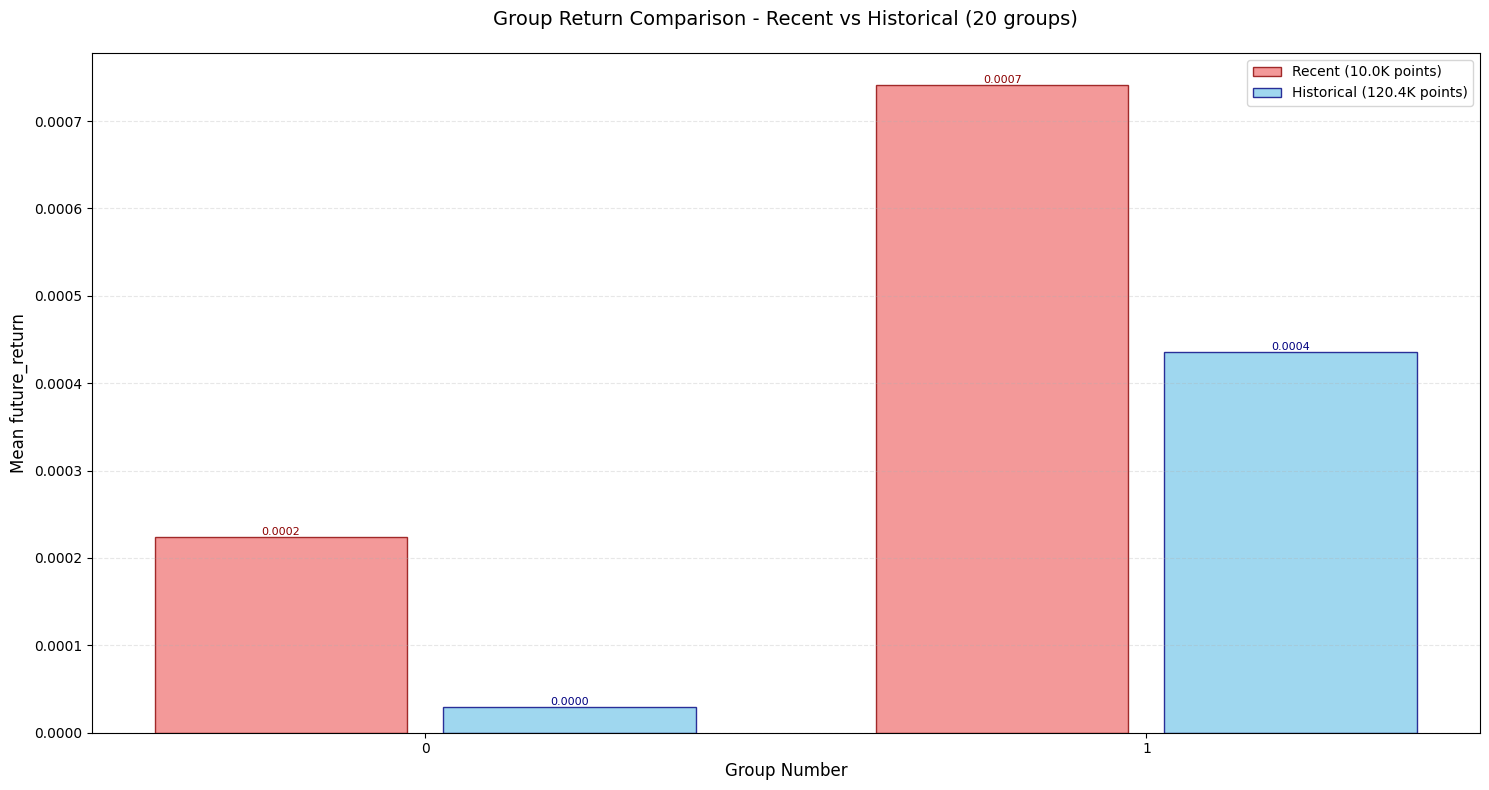

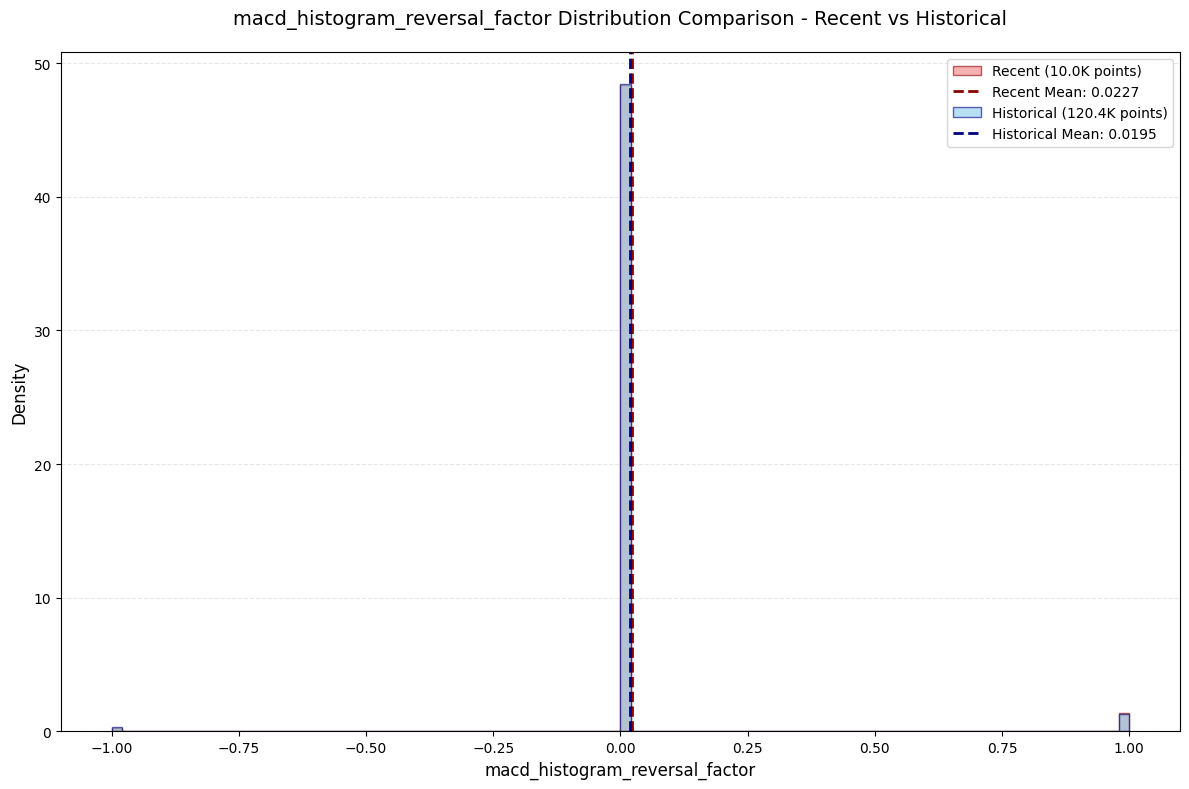

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)